In [1]:
from glob import glob
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [7]:
base_path = 'C:\\Users\\nicky\\Desktop\\signlanguage\\dataset'

img_list = glob(os.path.join(base_path, 'train', '*.jpg'))

print(len(img_list))

1512


In [8]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=1,
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.1)

[[ 25.885042   49.25965    24.686264   40.196766  131.21724     1.0192434
   34.965027  130.32124     9.74981    36.032616  144.78363    43.504353
   46.399868  144.43106    25.489758 ]]


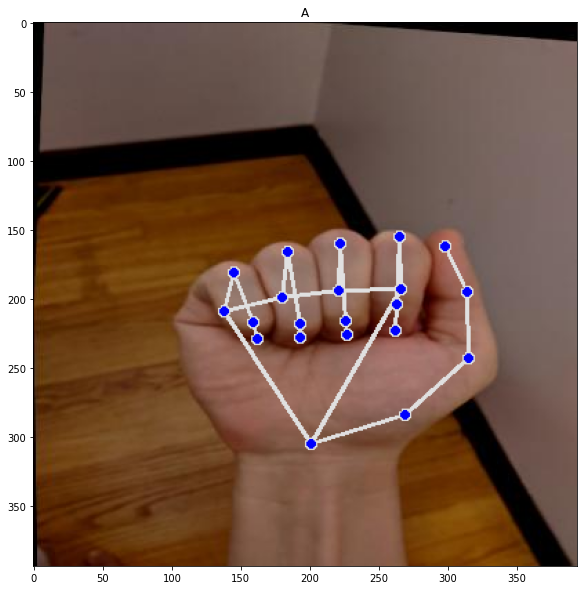

In [9]:
img_path = img_list[3]
img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = hands.process(img)

data = None

if result.multi_hand_landmarks is not None:
    for res in result.multi_hand_landmarks:
        joint = np.zeros((21, 3))
        for j, lm in enumerate(res.landmark):
            joint[j] = [lm.x, lm.y, lm.z]

        # Compute angles between joints
        v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
        v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
        v = v2 - v1 # [20,3]
        # Normalize v
        v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

        # Get angle using arcos of dot product
        angle = np.arccos(np.einsum('nt,nt->n',
            v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
            v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

        angle = np.degrees(angle) # Convert radian to degree

        data = np.array([angle], dtype=np.float32)
        
        print(data)
        
        mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)
else:
    print('Detection failed!')

plt.figure(figsize=(10, 10))
plt.title(os.path.basename(img_path)[0])
plt.imshow(img)

In [10]:
classes = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
    'W', 'X', 'Y', 'Z'
]

data_list = []

for img_path in tqdm(img_list):
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)

    data = None
    label = None

    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 3))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
            v = v2 - v1 # [20,3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            data = np.array([angle], dtype=np.float32)

            label = os.path.basename(img_path)[0]
            label_id = classes.index(label)
            
            data = np.append(data, label_id)
            
            data_list.append(data)
            
print(len(data_list))

100%|██████████████████████████████████████████████████████████████████████████████| 1512/1512 [01:35<00:00, 15.89it/s]

1216


In [11]:
np.savetxt('handtrain.csv', data_list, delimiter=',')